In this notebook, I will answer these question : 

1.How to check listing with good ratings

2.How listing with superhost perform compare to normal listing



In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS


In [82]:
listing = pd.read_csv('data/listings.csv')
calendar = pd.read_csv('data/calendar.csv')
review = pd.read_csv('data/reviews.csv')

In [101]:
new_listing_df = listing.dropna(subset=['review_scores_rating'])
new_listing_df['price'] =  [np.nan if str(x) == 'nan' else float(str(x).replace('$','').replace(',','')) for x in new_listing_df.price]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
len(listing)

3585

22.6% of the dataset does not have review_scores_rating as shown below

Next, we can check how the listing features affect the ratings. First we can determine the feature.

In [103]:
features = new_listing_df[['host_listings_count', 'host_total_listings_count', 'accommodates', 
                     'bathrooms', 'bedrooms', 'beds','guests_included','review_scores_rating','price']]

Process amenities data by splitting it into separate features

In [104]:
new_listing_df['amenities'].head(10)

1     {TV,Internet,"Wireless Internet","Air Conditio...
2     {TV,"Cable TV","Wireless Internet","Air Condit...
3     {TV,Internet,"Wireless Internet","Air Conditio...
4     {Internet,"Wireless Internet","Air Conditionin...
5     {"Cable TV","Wireless Internet","Air Condition...
6     {TV,Internet,"Wireless Internet",Kitchen,"Free...
7     {TV,Internet,"Wireless Internet","Air Conditio...
8     {"Wireless Internet","Pets live on this proper...
9     {TV,"Cable TV",Internet,"Wireless Internet","A...
10    {TV,"Wireless Internet","Air Conditioning",Kit...
Name: amenities, dtype: object

In [105]:
amenities = np.unique(np.concatenate([amns.replace('"','').replace('{','').replace('}','').split(',') for amns in new_listing_df['amenities']],axis=None))[1:]
amenity_arr = np.array([new_listing_df['amenities'].map(lambda amns: 1 if amn in amns else 0) for amn in amenities])
features = pd.concat([features, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)

we can use the feature with true and false values as well.

In [106]:
for tf_feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    features[tf_feature] = new_listing_df[tf_feature].map(lambda s: 0 if s == "f" else 1)

combining categorical feature

In [107]:
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    features = pd.concat([features, pd.get_dummies(new_listing_df[categorical_feature])], axis=1)

In [108]:
features.isna().sum()

host_listings_count          627
host_total_listings_count    627
accommodates                 627
bathrooms                    639
bedrooms                     634
                            ... 
Airbed                       627
Couch                        627
Futon                        627
Pull-out Sofa                627
Real Bed                     627
Length: 107, dtype: int64

Looking at the numbers of rows that consistent accros all features, we can drop these dirty rows

In [109]:
features = features.dropna(axis=0)

In [110]:
features.columns

Index(['host_listings_count', 'host_total_listings_count', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included',
       'review_scores_rating', 'price', '24-Hour Check-in',
       ...
       'Townhouse', 'Villa', 'Entire home/apt', 'Private room', 'Shared room',
       'Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed'],
      dtype='object', length=107)

Let's see how the feature correlate with rating.

In [111]:
features.corr().review_scores_rating.sort_values(ascending=False)

review_scores_rating       1.000000
host_is_superhost          0.233151
Jamaica Plain              0.088224
price                      0.085690
host_identity_verified     0.077706
                             ...   
requires_license                NaN
Allston                         NaN
South Boston                    NaN
South Boston Waterfront         NaN
Entire Floor                    NaN
Name: review_scores_rating, Length: 107, dtype: float64

From the chart we can see host_is_superhost has the highest correlation with rating and the host_identity_verfied is second place.

This is superhost definition from AirBNB :

What is a Superhost? Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests.

Once a host reaches Superhost status, a badge superhost badge will automatically appear on their listing and profile to help you identify them.

We check Superhosts’ activity four times a year, to ensure that the program highlights the people who are most dedicated to providing outstanding hospitality.

In summary, superhosts are high quality hosts. So, logically this should be one of the best predictor of the ratings.

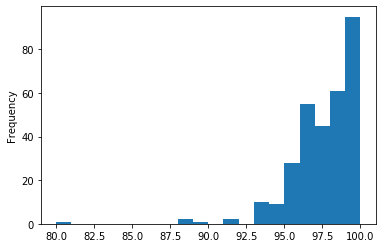

In [112]:
features[features.host_is_superhost==1].review_scores_rating.plot(kind='hist',bins=20)

Superhost has a very good rating distribution, with minimum rating in 80

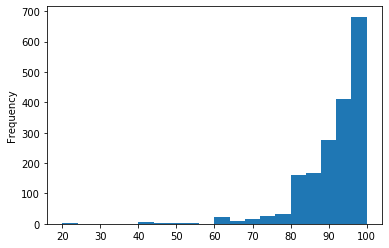

In [113]:
features[features.host_is_superhost==0].review_scores_rating.plot(kind='hist',bins=20)

While non superhost is having more wide rating value. The minimum is 20 and has a quite high number of ratings in 60-70.

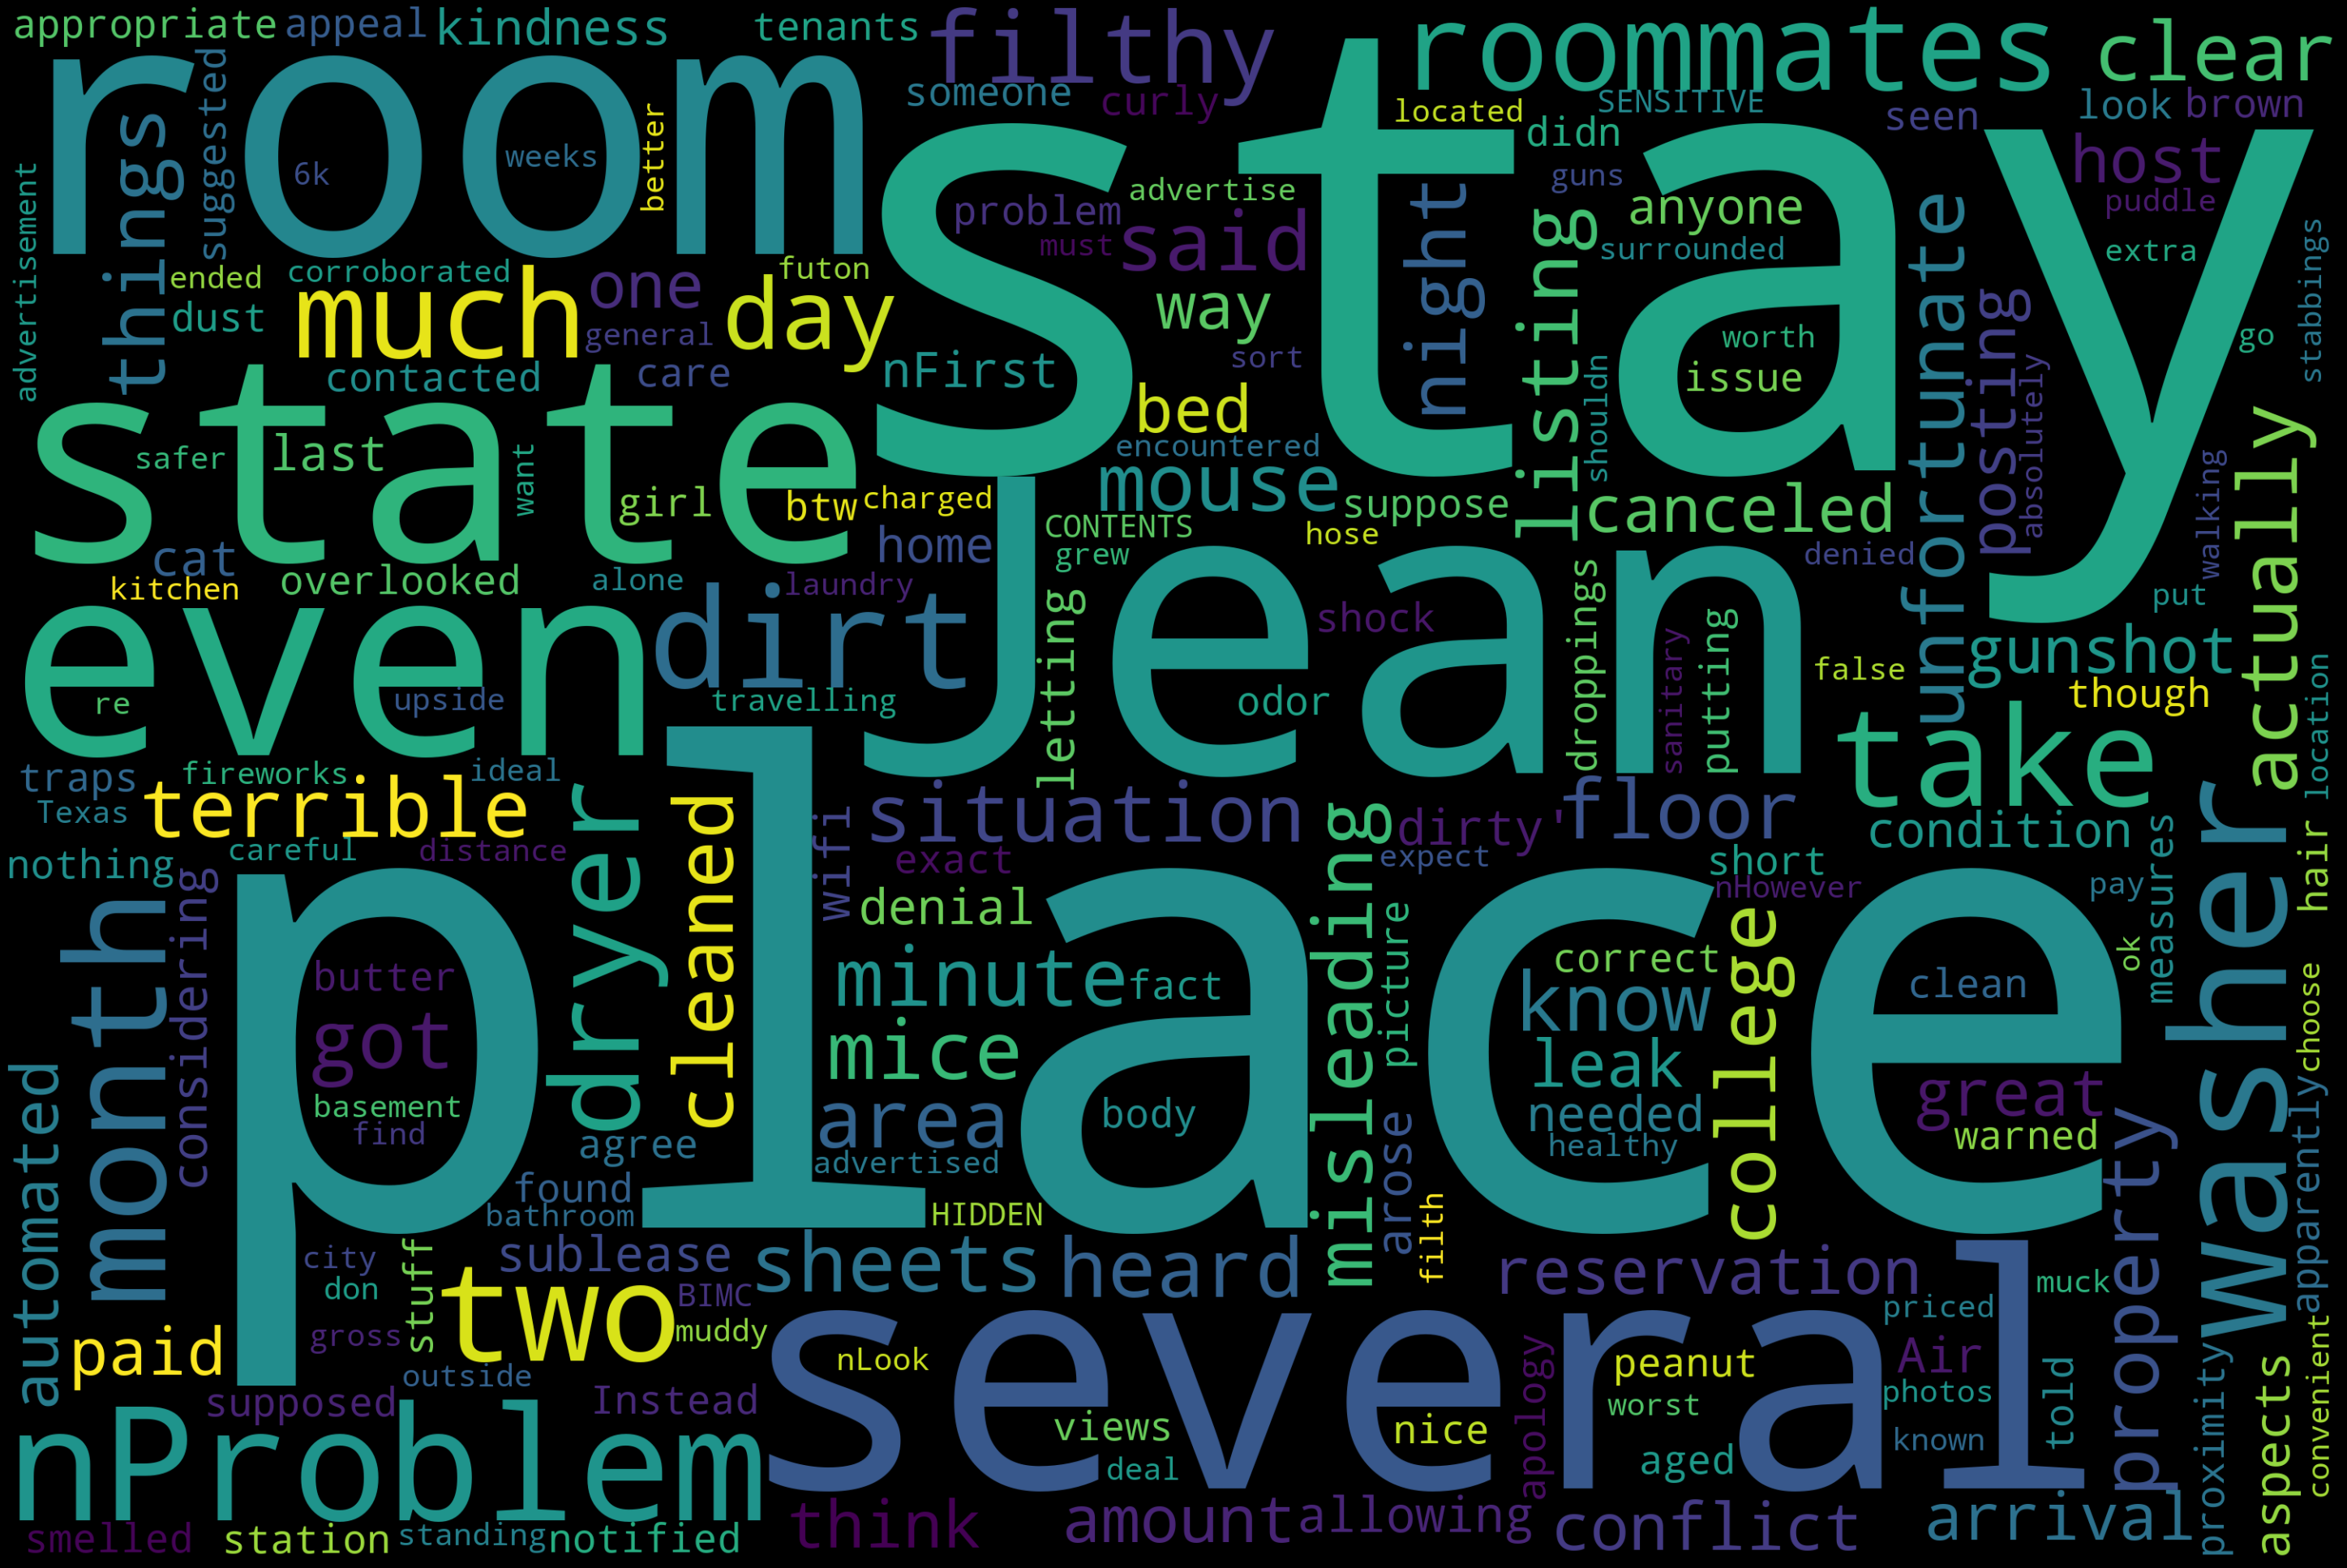

In [114]:
df_merge_difkey = pd.merge(review, new_listing_df, left_on='listing_id', right_on='id')
text = df_merge_difkey[df_merge_difkey.review_scores_rating < 40].comments.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

While looking at wordcloud comments on listing with rating < 60, it is very interesting that several negative comments is appear.


The example is : gunshot, guns, misleading, terrible, dirty, mice, mouse etc.

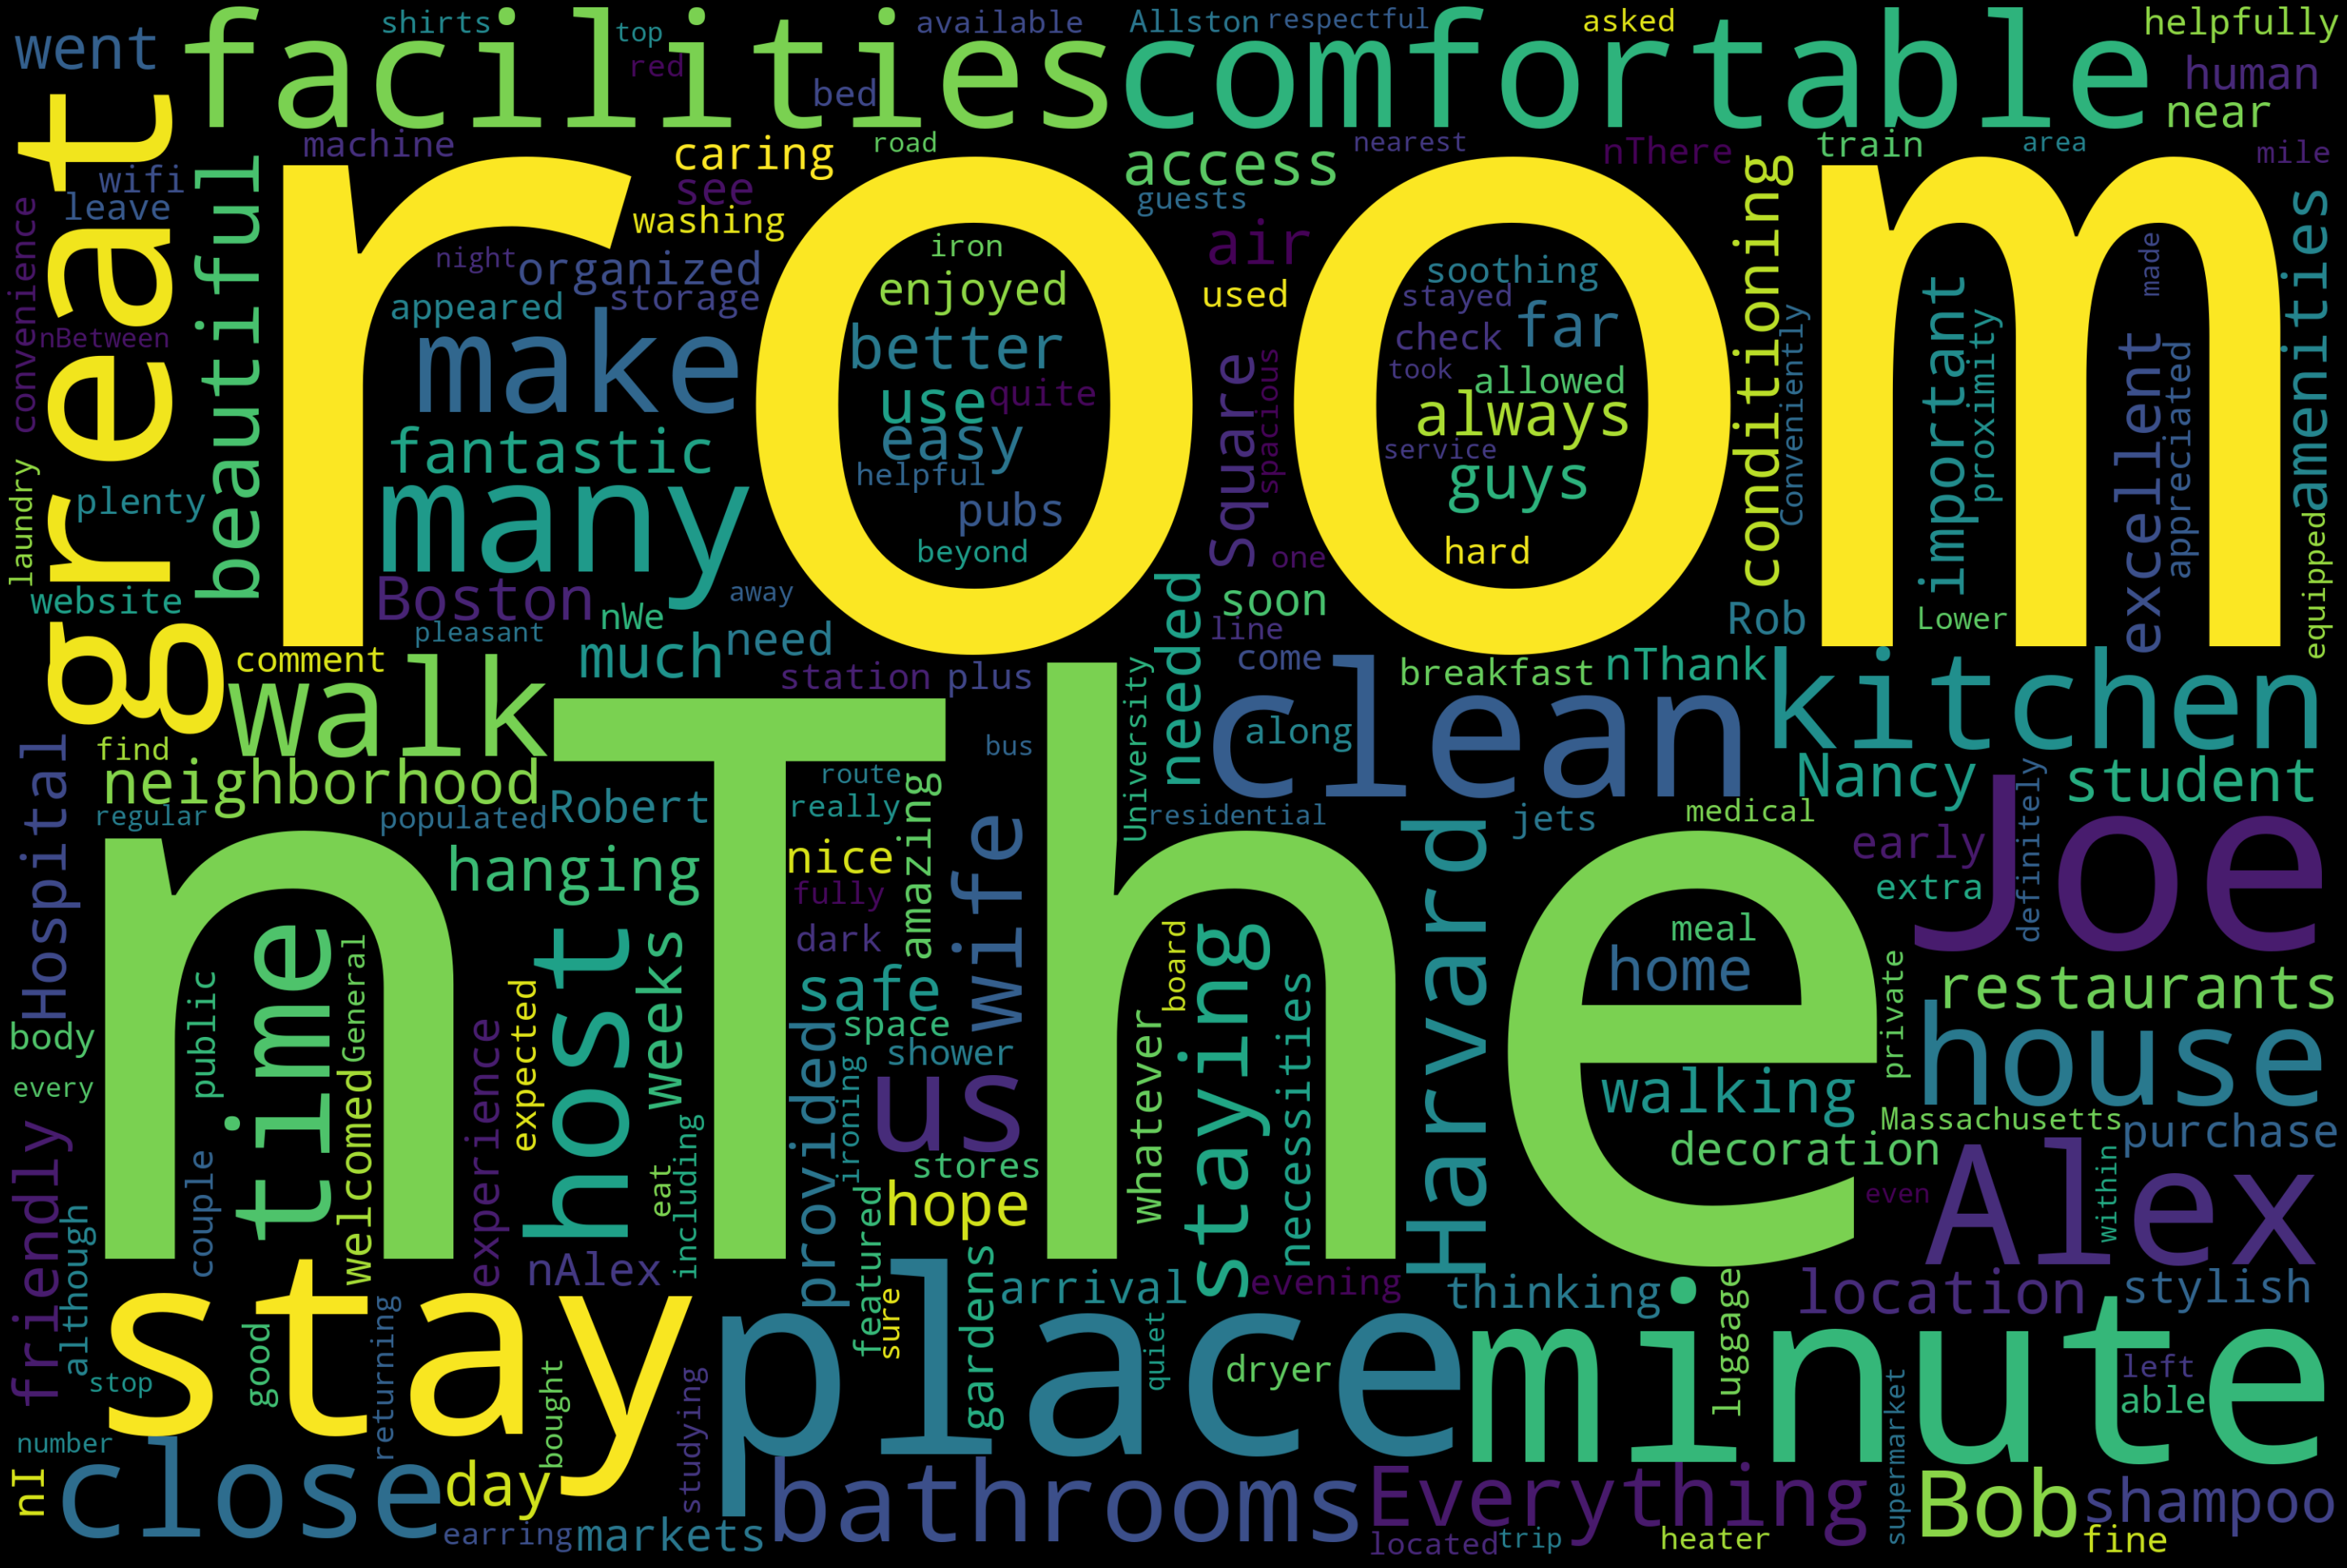

In [115]:
text = df_merge_difkey[df_merge_difkey.review_scores_rating > 90].comments.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

On the other hand, for listing with rating > 90 it is mostly has positive comments like : clean, comfortable, beautiful, caring.

Let's check the price correlation with other feature

In [116]:
features.corr().price.sort_values(ascending=False)

price                      1.000000
accommodates               0.577492
bedrooms                   0.547480
Entire home/apt            0.542198
beds                       0.505079
                             ...   
requires_license                NaN
Allston                         NaN
South Boston                    NaN
South Boston Waterfront         NaN
Entire Floor                    NaN
Name: price, Length: 107, dtype: float64

Accomodates and bedrooms has high correlation with price, this is make sense as the number of people and bedrooms will increase the price of rental. Surprisingly, **Downtown** (location) is not part of the feature that has high correlation with price.

Next we can do the prediction on the ratings

In [144]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [145]:
y = features['review_scores_rating']
X = features.drop('review_scores_rating', axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .40, random_state=42)


In [146]:
clf_lr = LinearRegression()
clf_las = Lasso()
clf_rf = RandomForestRegressor()
y = features['review_scores_rating']
x = features.drop('review_scores_rating', axis='columns')
clf_lr.fit(X_train, y_train)
clf_las.fit(X_train, y_train)
clf_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [147]:
y_pred_train_lr = clf_lr.predict(X_train)
y_pred_train_las = clf_las.predict(X_train)
y_pred_train_rf = clf_rf.predict(X_train)

In [148]:
print('linear regression r2 score : ',r2_score(y_train, y_pred_train_lr))
print('lasso r2 score : ',r2_score(y_train, y_pred_train_las))
print('random forrest r2 score : ',r2_score(y_train, y_pred_train_rf))

linear regression r2 score :  0.19516227791344298
lasso r2 score :  0.05363505255480028
random forrest r2 score :  0.8763427553044796


Random forrest has the highest score compare to other 2. Let's compare on test set

In [149]:
y_pred_test_lr = clf_lr.predict(X_test)
y_pred_test_las = clf_las.predict(X_test)
y_pred_test_rf = clf_rf.predict(X_test)

In [150]:
print('linear regression r2 score : ',r2_score(y_test, y_pred_test_lr))
print('lasso r2 score : ',r2_score(y_test, y_pred_test_las))
print('random forrest r2 score : ',r2_score(y_test, y_pred_test_rf))

linear regression r2 score :  0.011422231650726977
lasso r2 score :  0.030793319618092396
random forrest r2 score :  0.1288344143703508


Turns out random forrest has overfitting problem...Let's find optimal model

In [151]:
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response

        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    rf_model = RandomForestRegressor() 
    rf_model.fit(X_train, y_train)
        
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

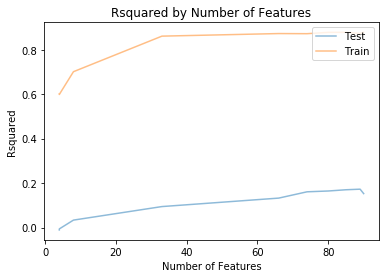

In [156]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
r2_test, r2_train, rf_model, X_train, X_test, y_train, y_test = find_optimal_rf_mod(X, y, cutoffs)

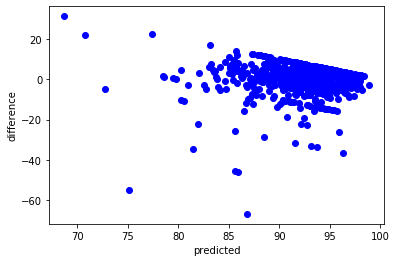

In [153]:
y_test_preds = rf_model.predict(X_test)

preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

It is still overfit, we can use gridsearch to find the best parameters and avoid overfit

In [154]:
from sklearn.model_selection import GridSearchCV

### Let's see what be the best number of features to use based on the test set performance
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True, param_grid=None):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        if param_grid==None:
            rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

        else:
            rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
            rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
            
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    if param_grid==None:
        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

    else:
        rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
        rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
    rf_model.fit(X_train, y_train)
     
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


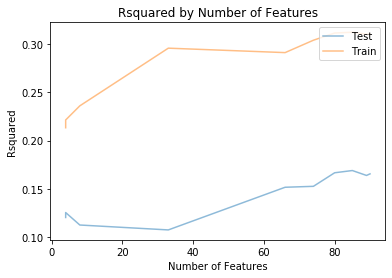

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [157]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
params = {'n_estimators': [10, 100, 1000], 'max_depth': [1, 5, 10, 100]}
r2_test, r2_train, rf_model, X_train, X_test, y_train, y_test = find_optimal_rf_mod(X, y, cutoffs, param_grid=params)

still overfitting happens..

In [158]:
importances=rf_model.best_estimator_.feature_importances_
df_importances = pd.concat([pd.DataFrame(x.columns,columns=['column_name']),pd.DataFrame(importances,columns=['importances'])], axis=1)
df_importances = df_importances.sort_values('importances',ascending=False)
df_importances.reset_index()

index                column_name  importances
0        7                      price     0.201235
1       49      Wheelchair Accessible     0.152809
2        1  host_total_listings_count     0.097986
3        0        host_listings_count     0.091726
4       66                Charlestown     0.041159
..     ...                        ...          ...
101    101                     Airbed          NaN
102    102                      Couch          NaN
103    103                      Futon          NaN
104    104              Pull-out Sofa          NaN
105    105                   Real Bed          NaN

[106 rows x 3 columns]

<Figure size 432x288 with 0 Axes>

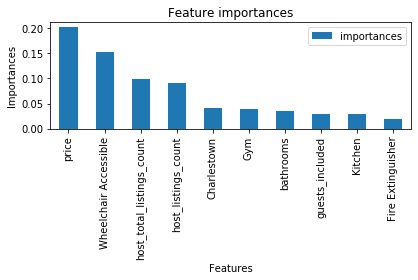

In [159]:
plt.figure()
df_importances.sort_values('importances',ascending=False).head(10).plot(x='column_name', y='importances',kind='bar', title='Feature importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.tight_layout()
plt.savefig('Importances',quality=100, optimize=True)